# Noise2Void Denoising with the Convallaria Dataset

The Convallaria dataset consists of 100 noisy images of the same field of view, allowing us to create a ground truth by averaging. This notebook demonstrates Noise2Void (N2V) denoising, which enables training from a single noisy image without requiring clean targets.


In [27]:
## Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tifffile import imread, imwrite
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.utils.metrics import scale_invariant_psnr
from careamics.utils import autocorrelation
from microssim import micro_structural_similarity
from PIL import Image

In [3]:
## Load the dataset

# Define paths to data files
conv_path = "/group/jug/datasets/Convallaria_diaphragm/20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif"
fd_path = "/group/jug/datasets/Convallaria_diaphragm/20190726_tl_50um_500msec_wf_130EM_FD.tif"

# Load the stacks
conv_stack = imread(conv_path)
fd_stack = imread(fd_path)

# Print shapes to check
print("Convallaria stack shape:", conv_stack.shape)
print("Field diaphragm stack shape:", fd_stack.shape)

Convallaria stack shape: (100, 1024, 1024)
Field diaphragm stack shape: (100, 1024, 1024)


## Let's create the ground truth

In [4]:
# Ground truth is the average of all frames
gt_image = np.mean(conv_stack, axis=0)

# Select a single noisy image for training (frame 50)
train_image = conv_stack[50]

print(f"Ground truth shape: {gt_image.shape}")
print(f"Training image shape: {train_image.shape}")

Ground truth shape: (1024, 1024)
Training image shape: (1024, 1024)


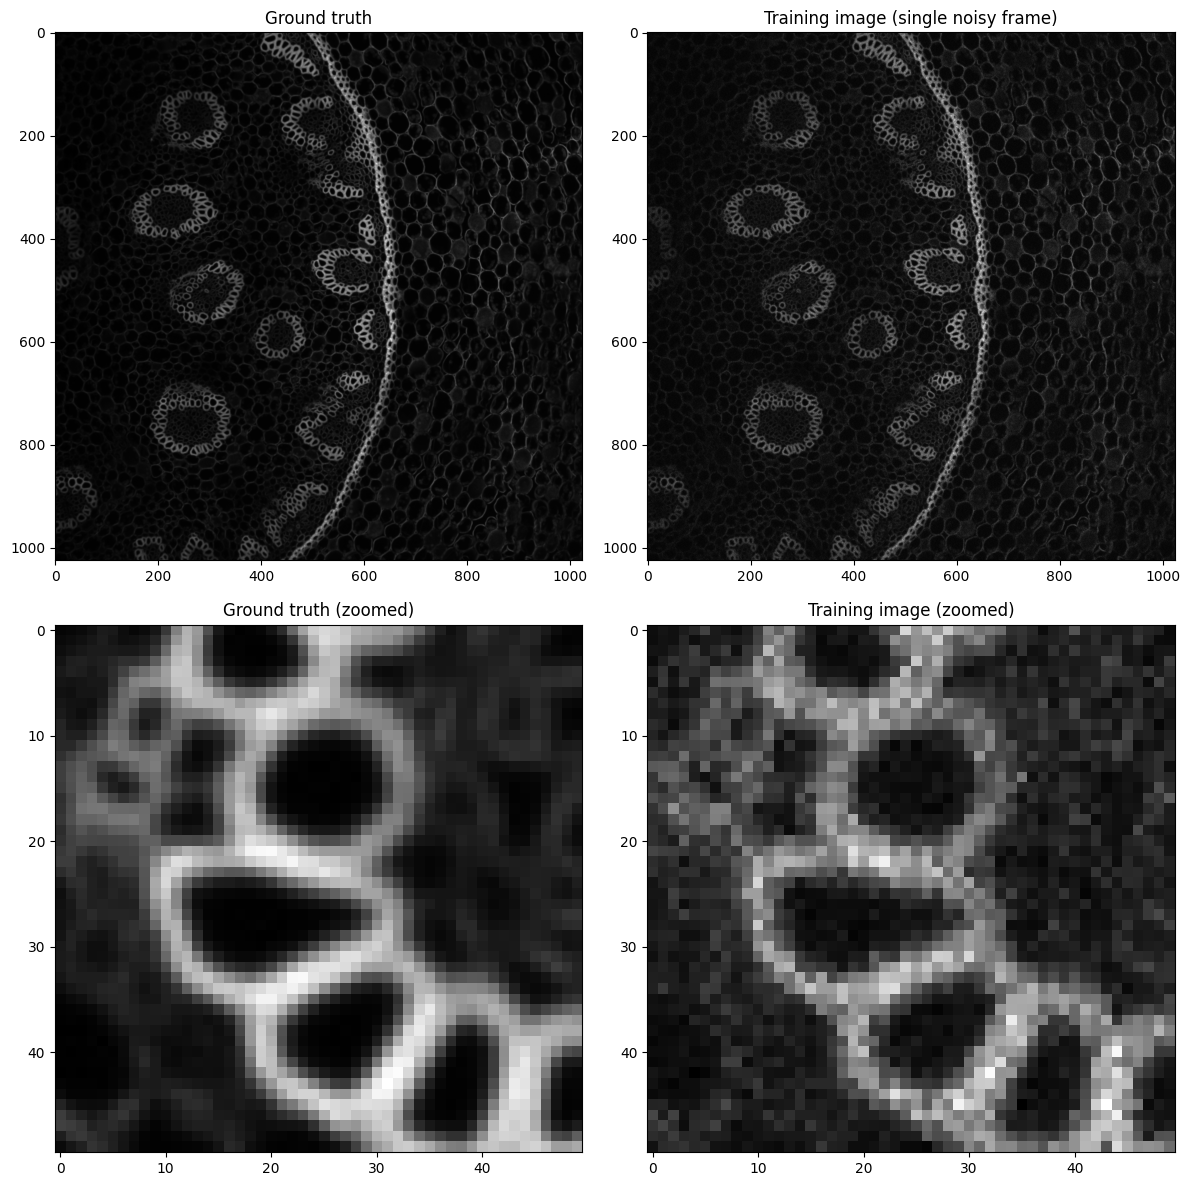

In [7]:
## Visualize the data
x_min, x_max = 580, 630
y_min, y_max = 380, 430

fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Full images
ax[0, 0].imshow(gt_image, cmap="gray")
ax[0, 0].set_title("Ground truth")
ax[0, 1].imshow(train_image, cmap="gray")
ax[0, 1].set_title("Training image (single noisy frame)")
# Zoomed regions
ax[1, 0].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 0].set_title("Ground truth (zoomed)")
ax[1, 1].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 1].set_title("Training image (zoomed)")

plt.tight_layout()
plt.show()

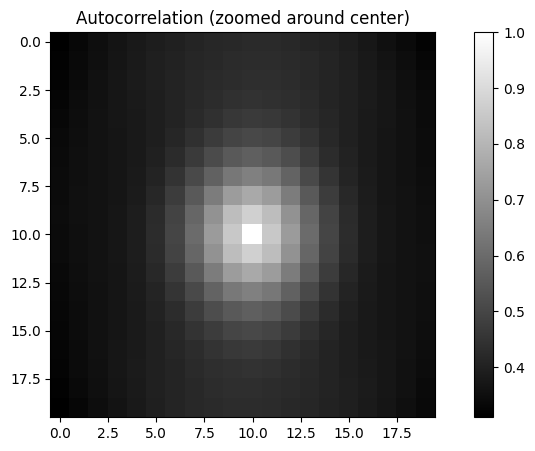

In [9]:
# Analyze noise characteristics

# Compute autocorrelation to check for structured noise
autocorr = autocorrelation(train_image)

# Crop autocorrelation around center
midpoint = train_image.shape[0] // 2
crop_size = 10
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)

# Plot autocorrelation
plt.figure(figsize=(10, 5))
plt.imshow(autocorr[slices], cmap="gray")
plt.title("Autocorrelation (zoomed around center)")
plt.colorbar()
plt.show()

## Now we need to configure the Noise2Void model

In [20]:
config = create_n2v_configuration(
    experiment_name="convallaria_n2v",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=100,
    masked_pixel_percentage=0.2,
    struct_n2v_axis="none",
    model_checkpoint={},  
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 16,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
     

## Initialize and train the model

In [21]:
careamist = CAREamist(source=config)

careamist.train(
    train_source=train_image,
    val_percentage=0.1, 
)

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Computed dataset mean: [825.70813084], std: [472.09773694]
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 56.31it/s, train_loss_step=0.166, val_loss=0.0821, train_loss_epoch=0.118] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 31.85it/s, train_loss_step=0.166, val_loss=0.0821, train_loss_epoch=0.118]


## Prediction with CAREamics

In [22]:
# Use tiling for prediction on the full image
prediction = careamist.predict(
    source=train_image, 
    tile_size=(256, 256),
    tile_overlap=(64, 64)
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mambaforge/envs/care/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

## Let's calculate some metrics and visualize Predictions vs Ground Truth

In [36]:
# Calculate PSNR and microSSIM
psnr_noisy = scale_invariant_psnr(gt_image, train_image)
psnr_denoised = scale_invariant_psnr(gt_image, prediction[0].squeeze())
microssim_noisy = micro_structural_similarity(train_image, gt_image)
microssim_denoised = micro_structural_similarity(prediction[0].squeeze(), gt_image)

# Print results
print(f"PSNR of noisy input: {psnr_noisy:.2f}")
print(f"PSNR of N2V denoised: {psnr_denoised:.2f}")
print(f"microSSIM of noisy input: {microssim_noisy:.3f}")
print(f"microSSIM of N2V denoised: {microssim_denoised:.3f}")

PSNR of noisy input: 32.38
PSNR of N2V denoised: 36.24
microSSIM of noisy input: 0.812
microSSIM of N2V denoised: 0.928


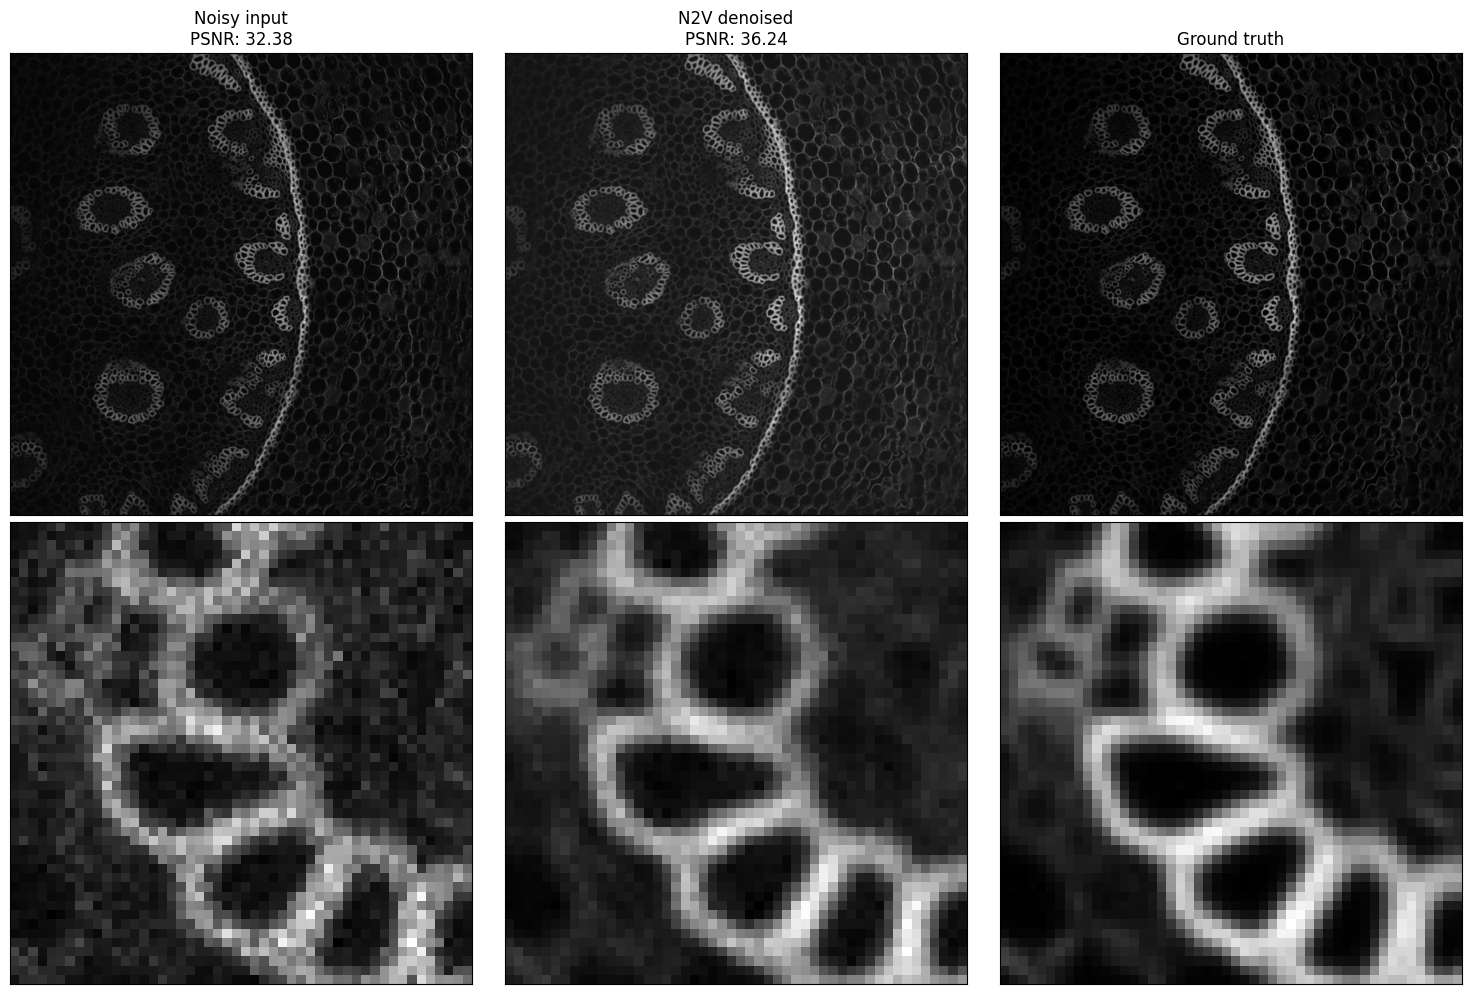

In [37]:
# Create visualization with full images and zoomed regions
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Full images - top row
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_title(f"Noisy input\nPSNR: {psnr_noisy:.2f}")
ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[0, 1].set_title(f"N2V denoised\nPSNR: {psnr_denoised:.2f}")
ax[0, 2].imshow(gt_image, cmap="gray")
ax[0, 2].set_title("Ground truth")

# Zoomed regions - bottom row
ax[1, 0].imshow(train_image[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 1].imshow(prediction[0].squeeze()[x_min:x_max, y_min:y_max], cmap="gray")
ax[1, 2].imshow(gt_image[x_min:x_max, y_min:y_max], cmap="gray")

# Remove ticks
for i in range(2):
    for j in range(3):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## Get Losses

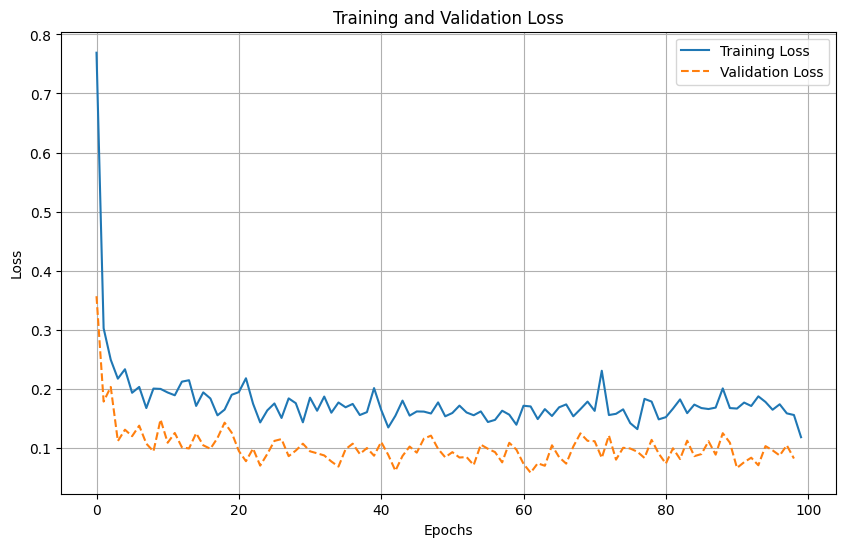

In [38]:
# Retrieve the training and validation losses
losses = careamist.get_losses()

# Extract train and validation losses
train_losses = losses.get('train_loss', [])
val_losses = losses.get('val_loss', [])
train_epochs = list(range(len(train_losses)))
val_epochs = list(range(len(val_losses)))

# Plot the losses
plt.figure(figsize=(10, 6))
if train_losses:
    plt.plot(train_epochs, train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_epochs, val_losses, label='Validation Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

## And you're done! Let's create a cover 

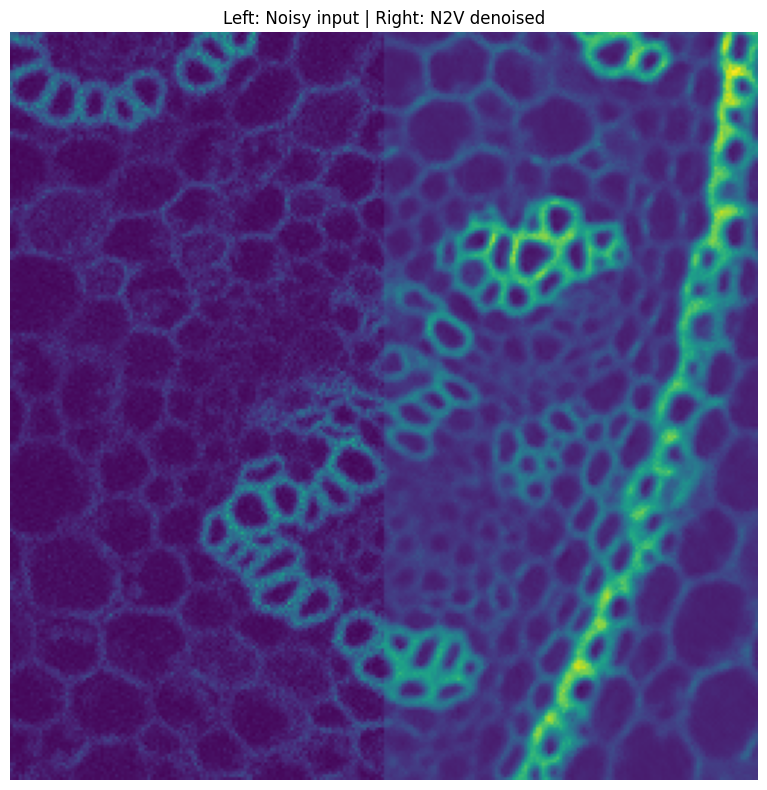

In [46]:
x_start = 400
y_start = 600
size = 256

# Normalize images
norm_noisy = (train_image - train_image.min()) / (train_image.max() - train_image.min())
norm_denoised = (prediction[0].squeeze() - prediction[0].squeeze().min()) / (prediction[0].squeeze().max() - prediction[0].squeeze().min())

# Create image canvas
cover = np.zeros((size, size))
cover[:, :size//2] = norm_noisy[y_start:y_start+size, x_start:x_start+size//2]
cover[:, size//2:] = norm_denoised[y_start:y_start+size, x_start+size//2:x_start+size]

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(cover, cmap="viridis")
plt.title("Left: Noisy input | Right: N2V denoised")
plt.axis('off')
plt.tight_layout()
plt.savefig("Convallaria_N2V_new_region_comparison.jpg", dpi=300, bbox_inches='tight')
plt.show()

## Finally, let's export the model to BMZ

In [42]:
general_description = """
This model is trained using the Noise2Void (N2V) algorithm to denoise Convallaria microscopy images.
N2V enables training without clean data by masking pixels and predicting their values from surrounding context.
The training data consists of a single noisy image of Convallaria (c. majalis) acquired by 
Britta Schroth-Diez of the MPI-CBG Light Microscopy Facility.
"""

careamist.export_to_bmz(
    path_to_archive="convallaria_n2v_model.zip",
    friendly_model_name="Convallaria_N2V",
    input_array=train_image.astype(np.float32),
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
    general_description=general_description,
    data_description="Convallaria (c. majalis) fluorescence microscopy with Andor iXon Ultra 888 Monochrome EMCCD camera (EM-gain 130)"
)

print("Notebook completed successfully!")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

computing SHA256 of inputs.npy (result: 29a290d8cf995b677271dc3562529226feee84867cebe4445ec8d8c1777ad3c7): 100%|██████████| 4194432/4194432 [00:00<00:00, 1102300934.54it/s]
computing SHA256 of outputs.npy (result: 0054765ae09cdf766fafb792bb02bdca6fb9f30c3f7676767b7a0032b876349e): 100%|██████████| 4194432/4194432 [00:00<00:00, 1022119620.92it/s]
computing SHA256 of environment.yml (result: fcb28a47de772ad4152cc36bed5c7166c0e67bcf50462610439fe1816b84d075): 100%|██████████| 157/157 [00:00<00:00, 245344.91it/s]
computing SHA256 of weights.pth (result: 659dfe01d93c380f2c7012a22a021d4cceeeb571998e2bab8bf99c136542a2b3): 100%|██████████| 2066750/2066750 [00:00<00:00, 1006452779.75it/s]
computing SHA256 of careamics.yaml (result: 92d3ea7e014973c900d3e2a044f768f655e72c6c813cd3681d248bca0ab20d8a): 100%|██████████| 1241/1241 [00:00<00:00, 2135000.52it/s]
2025-02-25 13:48:40.396 | Level 30 | bioimageio.spec.model.v0_5:_validate_documentation:2106 - documentation: No '# Validation' (sub)section foun

Notebook completed successfully!
